# 2. Machine Learning for Regression

In [12]:
import pandas as pd
import numpy as np

## 2.2 Data Preparation

In [13]:
# !unzip ./data/archive.zip

Or you can use `!wget $data` when you give an url to download the data.

In [14]:
data = "./data/data.csv"

In [15]:
df = pd.read_csv(data)

In [16]:
df.columns = df.columns.str.lower().str.replace(" ", "_")

In [17]:
strings = df.dtypes[df.dtypes == "object"].index
strings

Index(['make', 'model', 'engine_fuel_type', 'transmission_type',
       'driven_wheels', 'market_category', 'vehicle_size', 'vehicle_style'],
      dtype='object')

In [18]:
for col in strings:
    df[col] = df[col].str.lower().str.replace(" ", "_")

In [19]:
df.head()

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,bmw,1_series_m,2011,premium_unleaded_(required),335.0,6.0,manual,rear_wheel_drive,2.0,"factory_tuner,luxury,high-performance",compact,coupe,26,19,3916,46135
1,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,convertible,28,19,3916,40650
2,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,high-performance",compact,coupe,28,20,3916,36350
3,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,coupe,28,18,3916,29450
4,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,luxury,compact,convertible,28,18,3916,34500


In [20]:
df.dtypes

make                  object
model                 object
year                   int64
engine_fuel_type      object
engine_hp            float64
engine_cylinders     float64
transmission_type     object
driven_wheels         object
number_of_doors      float64
market_category       object
vehicle_size          object
vehicle_style         object
highway_mpg            int64
city_mpg               int64
popularity             int64
msrp                   int64
dtype: object

## 2.3 Exploratory data analysis

In [21]:
for col in df.columns:
    print(col)
    print(df[col].unique()[:10])
    print(df[col].nunique())
    print()

make
['bmw' 'audi' 'fiat' 'mercedes-benz' 'chrysler' 'nissan' 'volvo' 'mazda'
 'mitsubishi' 'ferrari']
48

model
['1_series_m' '1_series' '100' '124_spider' '190-class' '2_series' '200'
 '200sx' '240sx' '240']
914

year
[2011 2012 2013 1992 1993 1994 2017 1991 2016 1990]
28

engine_fuel_type
['premium_unleaded_(required)' 'regular_unleaded'
 'premium_unleaded_(recommended)' 'flex-fuel_(unleaded/e85)' 'diesel'
 'electric' 'flex-fuel_(premium_unleaded_recommended/e85)' 'natural_gas'
 'flex-fuel_(premium_unleaded_required/e85)'
 'flex-fuel_(unleaded/natural_gas)']
10

engine_hp
[335. 300. 230. 320. 172. 160. 130. 158. 240. 248.]
356

engine_cylinders
[ 6.  4.  5.  8. 12.  0. nan 10.  3. 16.]
9

transmission_type
['manual' 'automatic' 'automated_manual' 'direct_drive' 'unknown']
5

driven_wheels
['rear_wheel_drive' 'front_wheel_drive' 'all_wheel_drive'
 'four_wheel_drive']
4

number_of_doors
[ 2.  4.  3. nan]
3

market_category
['factory_tuner,luxury,high-performance' 'luxury,performance'


Distribution of price (target variable)

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# %matplotlib inline

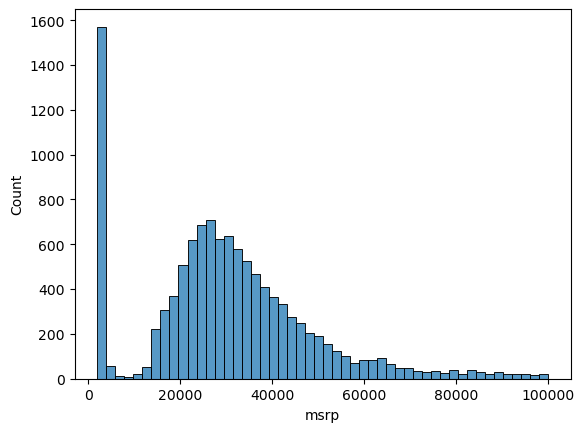

In [23]:
sns.histplot(df.msrp[df.msrp < 100_000], bins=50);

Long tail distribution.
ca 1600 cars (max) with price of \$ 1000, maybe min price for platform.
2nd peak around \$ 27000, with 750 cars.

Long tail not good for model, will be confused.
We want to get rid of the long tail. --> log transformation (remember log 0 is not defined)

In [24]:
np.log1p([0, 1, 10, 100, 1000, 10000])

array([0.        , 0.69314718, 2.39789527, 4.61512052, 6.90875478,
       9.21044037])

In [25]:
price_logs = np.log1p(df.msrp)

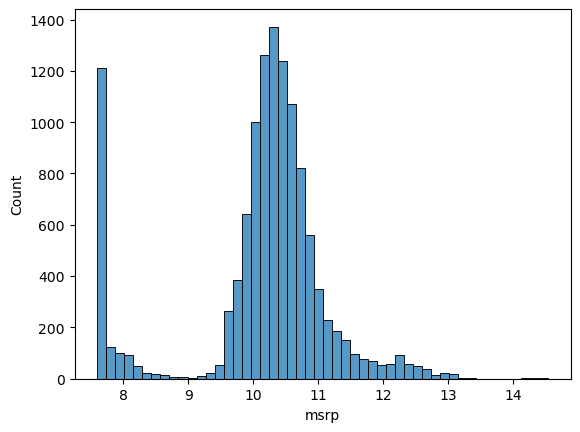

In [26]:
sns.histplot(price_logs, bins=50);

Now data resembles normal distribution.

Ideal for models, if data looks like bell shape.

### Missing values

In [27]:
df.isnull().sum()

make                    0
model                   0
year                    0
engine_fuel_type        3
engine_hp              69
engine_cylinders       30
transmission_type       0
driven_wheels           0
number_of_doors         6
market_category      3742
vehicle_size            0
vehicle_style           0
highway_mpg             0
city_mpg                0
popularity              0
msrp                    0
dtype: int64

## 2.4 Setting up the validation framework

Let's draw it.

<!-- ![Validation Framework](./images/validation_framework.png "Validation Framework") -->

<img src="./images/validation_framework.png" alt="Validation Framework" style="width:300px;height:auto;">

In [28]:
n = len(df)

n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - (n_val + n_test)

In [29]:
n, n_val + n_test + n_train

(11914, 11914)

Check size of data.

In [30]:
n_val, n_test, n_train

(2382, 2382, 7150)

In [31]:
df_train = df.iloc[n_train:]
df_val = df.iloc[n_train : n_train + n_val]
df_test = df.iloc[n_train + n_val :]

Not a good idea, because it sequential data, so we need to shuffle it. `make` for example is ordered.

In [32]:
idx = np.arange(n)

In [33]:
np.random.seed(2)
np.random.shuffle(idx)

In [34]:
df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train : n_train + n_val]]
df_test = df.iloc[idx[n_train + n_val :]]

In [104]:
df_train.head()

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,num_doors_2,num_doors_3,num_doors_4
0,chevrolet,cobalt,2008,regular_unleaded,148.0,4.0,manual,front_wheel_drive,2.0,NaN,compact,coupe,33,24,1385,1,0,0
1,toyota,matrix,2012,regular_unleaded,132.0,4.0,automatic,front_wheel_drive,4.0,hatchback,compact,4dr_hatchback,32,25,2031,0,0,1
2,subaru,impreza,2016,regular_unleaded,148.0,4.0,automatic,all_wheel_drive,4.0,hatchback,compact,4dr_hatchback,37,28,640,0,0,1
3,volkswagen,vanagon,1991,regular_unleaded,90.0,4.0,manual,rear_wheel_drive,3.0,NaN,large,passenger_minivan,18,16,873,0,1,0
4,ford,f-150,2017,flex-fuel_(unleaded/e85),385.0,8.0,automatic,four_wheel_drive,4.0,flex_fuel,large,crew_cab_pickup,21,15,5657,0,0,1


In [105]:
len(df_train), len(df_val), len(df_test)

(7150, 2382, 2382)

In [37]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [38]:
y_train = np.log1p(df_train.msrp.values)
y_val = np.log1p(df_val.msrp.values)
y_test = np.log1p(df_test.msrp.values)

In [39]:
del df_train["msrp"]
del df_val["msrp"]
del df_test["msrp"]

## 2.5 Linear Regression

In [40]:
df_train.iloc[10]

make                                 rolls-royce
model                     phantom_drophead_coupe
year                                        2015
engine_fuel_type     premium_unleaded_(required)
engine_hp                                  453.0
engine_cylinders                            12.0
transmission_type                      automatic
driven_wheels                   rear_wheel_drive
number_of_doors                              2.0
market_category        exotic,luxury,performance
vehicle_size                               large
vehicle_style                        convertible
highway_mpg                                   19
city_mpg                                      11
popularity                                    86
Name: 10, dtype: object

We take `engine_hp`, `city_mpg` and `popularity` as features.

In [41]:
xi = [453, 11, 86]  # feature matrix

In [42]:
def g(xi):
    # do something
    return 10_000  # needs implementation!!!

In [43]:
g(xi)

10000

Let's draw it.

<img src="./images/lin_regression.png" alt="Linear Regression" style="width:300px;height:auto;">

more compact:

<img src="./images/lin_regression_compact.png" alt="Linear Regression compact" style="width:300px;height:auto;">

In [44]:
w0 = 7.17
w = [0.01, 0.04, 0.002]

In [45]:
def linear_regression(xi):
    n = len(xi)

    pred = w0

    for j in range(n):
        pred += w[j] * xi[j]
    return pred

In [46]:
linear_regression(xi)

12.312

In [47]:
np.expm1(12.312)

222347.2221101062

## 2.6 Linear regression vector form

In [48]:
def dot(xi, w):
    n = len(xi)

    res = 0.0
    for j in range(n):
        res += xi[j] * w[j]
    return res

In [49]:
def linear_regression(xi):
    return w0 + dot(xi, w)

In [50]:
w_new = [w0] + w

In [51]:
def linear_regression(xi):
    xi = [1] + xi
    return dot(xi, w_new)

In [52]:
linear_regression(xi)

12.312

In [53]:
w0 = 7.17
w = [0.01, 0.04, 0.002]
w_new = [w0] + w

In [54]:
x1 = [1, 148, 24, 1385]
x2 = [1, 132, 25, 2031]
x10 = [1, 453, 11, 86]

X = [x1, x2, x10]
X = np.array(X)
X

array([[   1,  148,   24, 1385],
       [   1,  132,   25, 2031],
       [   1,  453,   11,   86]])

In [55]:
def linear_regression(X):
    return X.dot(w_new)

In [56]:
linear_regression(X)

array([12.38 , 13.552, 12.312])

## 2.7 Training a linear regression model

In [57]:
def train_linear_regression(X, y):
    pass

In [58]:
X = [
    [148, 24, 1385],
    [132, 25, 2031],
    [453, 11, 86],
    [158, 24, 185],
    [172, 25, 201],
    [413, 11, 86],
    [38, 54, 185],
    [142, 25, 431],
    [453, 31, 86],
]

X = np.array(X)
X

array([[ 148,   24, 1385],
       [ 132,   25, 2031],
       [ 453,   11,   86],
       [ 158,   24,  185],
       [ 172,   25,  201],
       [ 413,   11,   86],
       [  38,   54,  185],
       [ 142,   25,  431],
       [ 453,   31,   86]])

In [59]:
# Bias term
ones = np.ones(X.shape[0])
ones

array([1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [60]:
X = np.column_stack([ones, X])

In [61]:
y = [10000, 20000, 15000, 20050, 10000, 20000, 15000, 25000, 12000]

In [62]:
XTX = X.T.dot(X)
XTX_inv = np.linalg.inv(XTX)
# XTX.dot(XTX_inv).round(1)
w_full = XTX_inv.dot(X.T).dot(y)

In [63]:
w0 = w_full[0]
w = w_full[1:]

In [64]:
w0, w

(25844.75405576683, array([ -16.08906468, -199.47254894,   -1.22802883]))

In [115]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)

    return w_full[0], w_full[1:]

In [116]:
train_linear_regression(X, y)

(2.0460143454602068e+20,
 array([1.26525728e+20, 8.71025484e+01, 2.59709297e+02, 0.00000000e+00]))

## 2.8 Car price baseline model

In [67]:
df_train.columns

Index(['make', 'model', 'year', 'engine_fuel_type', 'engine_hp',
       'engine_cylinders', 'transmission_type', 'driven_wheels',
       'number_of_doors', 'market_category', 'vehicle_size', 'vehicle_style',
       'highway_mpg', 'city_mpg', 'popularity'],
      dtype='object')

In [68]:
base = ["engine_hp", "engine_cylinders", "highway_mpg", "city_mpg", "popularity"]

In [69]:
X_train = df_train[base].values

In this case filling missing values with zeros works well. Not always a good idea. Technically it doesn't make sense, for example for `engine_hp`, a car with 0 hp doesn't exist.

In [70]:
X_train = df_train[base].fillna(0).values

In [71]:
w0, w = train_linear_regression(X_train,y_train)

In [72]:
y_pred = w0 + X_train.dot(w)

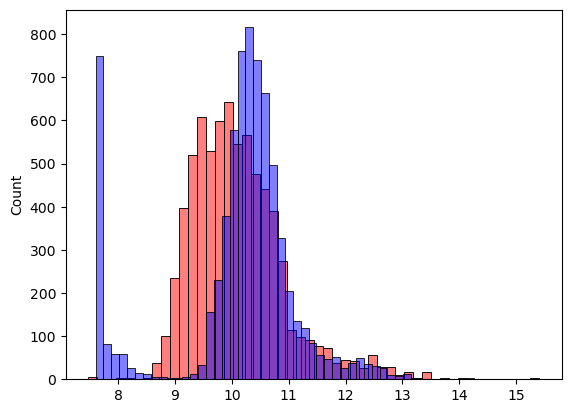

In [73]:
sns.histplot(y_pred, color="red", alpha=0.5, bins=50)
sns.histplot(y_train, color="blue", alpha=0.5, bins=50);

## 2.9 RMSE

<img src="./images/RMSE.png" alt="RMSE" style="width:300px;height:auto;">

In [74]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [75]:
rmse(y_train, y_pred)

0.7554192603920132

## 2.10 Validating the model

In [76]:
# base = ["engine_hp", "engine_cylinders", "highway_mpg", "city_mpg", "popularity"]
# X_train = df_train[base].fillna(0).values
# w0, w = train_linear_regression(X_train, y_train)
# y_pred = w0 + X_train.dot(w)

In [77]:
def prepare_X(df):
    df_num = df[base]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [78]:
X_train = prepare_X(df_train)
w0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)

rmse(y_val, y_pred)

0.7616530991301578

## 2.11 Simple feature engineering

In [79]:
2017 - df_train.year

0        9
1        5
2        1
3       26
4        0
        ..
7145     2
7146     2
7147     2
7148     3
7149     0
Name: year, Length: 7150, dtype: int64

In [80]:
def prepare_X(df):
    df = df.copy()

    df["age"] = 2017 - df.year
    features = base + ["age"]

    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [81]:
X_train = prepare_X(df_train)

In [82]:
X_train = prepare_X(df_train)
w0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)

rmse(y_val, y_pred)

0.5172055461058291

<Axes: ylabel='Count'>

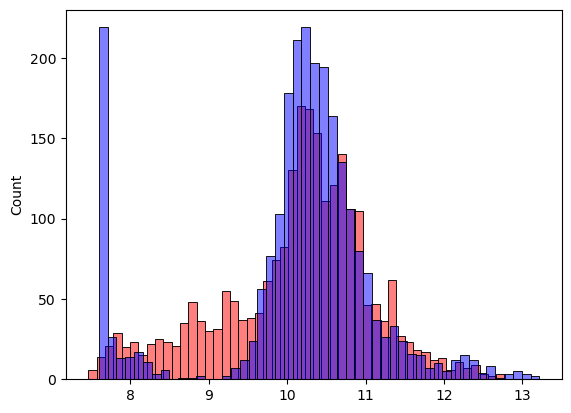

In [83]:
sns.histplot(y_pred, color="red", alpha=0.5, bins=50)
sns.histplot(y_val, color="blue", alpha=0.5, bins=50)

## 2.12 Categorical variables

In [84]:
for v in [2, 3, 4]:
    df_train["num_doors_%s" % v] = (df_train.number_of_doors == v).astype(int)


In [117]:
df_train

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,num_doors_2,num_doors_3,num_doors_4
0,chevrolet,cobalt,2008,regular_unleaded,148.0,4.0,manual,front_wheel_drive,2.0,NaN,compact,coupe,33,24,1385,1,0,0
1,toyota,matrix,2012,regular_unleaded,132.0,4.0,automatic,front_wheel_drive,4.0,hatchback,compact,4dr_hatchback,32,25,2031,0,0,1
2,subaru,impreza,2016,regular_unleaded,148.0,4.0,automatic,all_wheel_drive,4.0,hatchback,compact,4dr_hatchback,37,28,640,0,0,1
3,volkswagen,vanagon,1991,regular_unleaded,90.0,4.0,manual,rear_wheel_drive,3.0,NaN,large,passenger_minivan,18,16,873,0,1,0
4,ford,f-150,2017,flex-fuel_(unleaded/e85),385.0,8.0,automatic,four_wheel_drive,4.0,flex_fuel,large,crew_cab_pickup,21,15,5657,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7145,bmw,4_series,2015,premium_unleaded_(required),300.0,6.0,automatic,rear_wheel_drive,2.0,"luxury,performance",midsize,convertible,31,20,3916,1,0,0
7146,volkswagen,beetle,2015,premium_unleaded_(recommended),210.0,4.0,automated_manual,front_wheel_drive,2.0,"hatchback,performance",compact,2dr_hatchback,30,24,873,1,0,0
7147,gmc,sierra_1500,2015,flex-fuel_(unleaded/e85),285.0,6.0,automatic,four_wheel_drive,4.0,flex_fuel,large,extended_cab_pickup,22,17,549,0,0,1
7148,rolls-royce,ghost,2014,premium_unleaded_(required),563.0,12.0,automatic,rear_wheel_drive,4.0,"exotic,luxury,performance",large,sedan,21,13,86,0,0,1


In [86]:
df_train.number_of_doors.value_counts()

number_of_doors
4.0    5000
2.0    1916
3.0     228
Name: count, dtype: int64

In [87]:
def prepare_X(df):
    df = df.copy()
    features = base.copy()

    df["age"] = 2017 - df.year
    features.append("age")

    for v in [2, 3, 4]:
        df["num_doors_%s" % v] = (df.number_of_doors == v).astype(int)
        features.append("num_doors_%s" % v)

    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [118]:
prepare_X(df_train)

array([[148.,   4.,  33., ...,   0.,   0.,   0.],
       [132.,   4.,  32., ...,   0.,   0.,   0.],
       [148.,   4.,  37., ...,   0.,   0.,   0.],
       ...,
       [285.,   6.,  22., ...,   0.,   0.,   0.],
       [563.,  12.,  21., ...,   0.,   0.,   0.],
       [200.,   4.,  31., ...,   0.,   0.,   0.]])

In [89]:
X_train = prepare_X(df_train)
w0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)

rmse(y_val, y_pred)

0.5157995641501765

In [119]:
makes = list(df.make.value_counts().head().index)

In [120]:
def prepare_X(df):
    df = df.copy()
    features = base.copy()

    df["age"] = 2017 - df.year
    features.append("age")

    for v in [2, 3, 4]:
        df["num_doors_%s" % v] = (df.number_of_doors == v).astype(int)
        features.append("num_doors_%s" % v)

    for v in makes:
        df["make_%s" % v] = (df.make == v).astype(int)
        features.append("make_%s" % v)

    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [121]:
X_train = prepare_X(df_train)
w0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)

rmse(y_val, y_pred)

0.5076038849556024

In [122]:
categorical_variables = ["make", "engine_fuel_type", "transmission_type", "driven_wheels", "market_category", "vehicle_size", "vehicle_style"]

In [128]:
categories = {}

for c in categorical_variables:
    categories[c] = list(df[c].value_counts().head().index)

In [129]:
categories

{'make': ['chevrolet', 'ford', 'volkswagen', 'toyota', 'dodge'],
 'engine_fuel_type': ['regular_unleaded',
  'premium_unleaded_(required)',
  'premium_unleaded_(recommended)',
  'flex-fuel_(unleaded/e85)',
  'diesel'],
 'transmission_type': ['automatic',
  'manual',
  'automated_manual',
  'direct_drive',
  'unknown'],
 'driven_wheels': ['front_wheel_drive',
  'rear_wheel_drive',
  'all_wheel_drive',
  'four_wheel_drive'],
 'market_category': ['crossover',
  'flex_fuel',
  'luxury',
  'luxury,performance',
  'hatchback'],
 'vehicle_size': ['compact', 'midsize', 'large'],
 'vehicle_style': ['sedan',
  '4dr_suv',
  'coupe',
  'convertible',
  '4dr_hatchback']}

In [130]:
def prepare_X(df):
    df = df.copy()
    features = base.copy()

    df["age"] = 2017 - df.year
    features.append("age")

    for v in [2, 3, 4]:
        df["num_doors_%s" % v] = (df.number_of_doors == v).astype(int)
        features.append("num_doors_%s" % v)

    for c, values in categories.items():
        for v in values :
            df["%s_%s" % (c,v)] = (df[c] == v).astype(int)
            features.append("%s_%s" % (c, v))

    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [131]:
X_train = prepare_X(df_train)
w0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)

rmse(y_val, y_pred)

275.424750352587

## 2.13 Regularization

In [88]:
X = [
    [4,4,4],
    [3,5,5],
    [5,1,1],
    [5,4,4],
    [7,5,5],
    [4,5,5.00000001]
]

X = np.array(X)
X

array([[4.        , 4.        , 4.        ],
       [3.        , 5.        , 5.        ],
       [5.        , 1.        , 1.        ],
       [5.        , 4.        , 4.        ],
       [7.        , 5.        , 5.        ],
       [4.        , 5.        , 5.00000001]])

In [89]:
y = [1,2,3,1,2,3]

In [90]:
XTX = X.T.dot(X)
XTX

array([[140.        , 111.        , 111.00000004],
       [111.        , 108.        , 108.00000005],
       [111.00000004, 108.00000005, 108.0000001 ]])

In [91]:
XTX_inv = np.linalg.inv(XTX)  # LinAlgError: Singular matrix

In [92]:
XTX_inv.dot(X.T).dot(y)

array([ 6.24269892e-01,  3.44329390e+06, -3.44329299e+06])

Adding small number to diagonal of matrix, to make it invertible.

In [93]:
XTX = [[1.0001, 2, 2], [2, 1.0001, 1.0000001], [2, 1.0000001, 1.0001]]

XTX = np.array(XTX)

In [94]:
np.linalg.inv(XTX)

array([[-3.33366691e-01,  3.33350007e-01,  3.33350007e-01],
       [ 3.33350007e-01,  5.00492166e+03, -5.00508835e+03],
       [ 3.33350007e-01, -5.00508835e+03,  5.00492166e+03]])

In [95]:
XTX = XTX + 0.01 * np.eye(3)

In [96]:
np.linalg.inv(XTX)

array([[ -0.33672286,   0.33503094,   0.33503094],
       [  0.33503094,  49.42083696, -49.59004434],
       [  0.33503094, -49.59004434,  49.42083696]])

Regularization means controlling the weights that they don't grow too much.

In [97]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)

    return w_full[0], w_full[1:]

In [98]:
X_train = prepare_X(df_train)
w0, w = train_linear_regression_reg(X_train, y_train, r=0.01)

X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)

rmse(y_val, y_pred)

0.45652199013448413

## 2.14 Tuning the model

Finding the best parameter `r` for the model.

In [99]:
for r in [0.0, 0.00001,0.0001, 0.001, 0.1, 1, 10]:
    X_train = prepare_X(df_train)
    w0, w = train_linear_regression_reg(X_train, y_train, r=r)

    X_val = prepare_X(df_val)
    y_pred = w0 + X_val.dot(w)
    score = rmse(y_val, y_pred)

    print(r, w0, score)

0.0 7.718018928092786e+16 275.424750352587
1e-05 8.992896615154718 0.4565170143935396
0.0001 6.30864749887889 0.45651706521523455
0.001 6.285563277652235 0.45651750878552005
0.1 6.191208700099937 0.456569276300935
1 5.634896669063172 0.45722043179932
10 4.2839801089807805 0.47014569320977395


In [100]:
r = 0.001
X_train = prepare_X(df_train)
w0, w = train_linear_regression_reg(X_train, y_train, r=r)

X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)
score = rmse(y_val, y_pred)
score

0.45651750878552005

## 2.15 Using the model

In [102]:
df_full_train = pd.concat([df_train, df_val])
df_full_train = df_full_train.reset_index(drop=True)

In [103]:
X_full_train = prepare_X(df_full_train)
X_full_train

array([[148.,   4.,  33., ...,   1.,   0.,   0.],
       [132.,   4.,  32., ...,   0.,   0.,   1.],
       [148.,   4.,  37., ...,   0.,   0.,   1.],
       ...,
       [332.,   8.,  23., ...,   0.,   0.,   0.],
       [148.,   4.,  34., ...,   0.,   0.,   0.],
       [290.,   6.,  25., ...,   0.,   0.,   0.]])

In [104]:
y_full_train = np.concatenate([y_train, y_val])

In [105]:
w0, w = train_linear_regression_reg(X_full_train, y_full_train, r=0.001)

In [106]:
w0

6.322856557672594

In [107]:
w

array([ 1.52506335e-03,  1.18188696e-01, -6.66105651e-03, -5.33413973e-03,
       -4.87603204e-05, -9.69091844e-02, -7.92622135e-01, -8.90863343e-01,
       -6.35102062e-01, -4.14339212e-02,  1.75560743e-01, -5.78067171e-04,
       -1.00563875e-01, -9.27549660e-02, -4.66859134e-01,  7.98659511e-02,
       -3.16047682e-01, -5.51981655e-01, -7.89525705e-02,  1.09429397e+00,
        9.18986428e-01,  1.14856383e+00,  2.65169974e+00,  5.08923049e-01,
        1.62945188e+00,  1.53015593e+00,  1.61733465e+00,  1.54533404e+00,
       -9.70559771e-02,  3.73062105e-02, -5.81767471e-02, -2.35940831e-02,
       -1.19357105e-02,  2.18895261e+00,  2.07458271e+00,  2.05916686e+00,
       -5.00802769e-02,  5.62184639e-02,  1.84794024e-01,  3.32646151e-01,
       -1.58817038e-01])

In [108]:
X_test = prepare_X(df_test)
y_pred = w0 + X_test.dot(w)
score = rmse(y_test, y_pred)
score

0.4517749307149671

In [109]:
car = df_test.iloc[20].to_dict()
car

{'make': 'toyota',
 'model': 'sienna',
 'year': 2015,
 'engine_fuel_type': 'regular_unleaded',
 'engine_hp': 266.0,
 'engine_cylinders': 6.0,
 'transmission_type': 'automatic',
 'driven_wheels': 'front_wheel_drive',
 'number_of_doors': 4.0,
 'market_category': nan,
 'vehicle_size': 'large',
 'vehicle_style': 'passenger_minivan',
 'highway_mpg': 25,
 'city_mpg': 18,
 'popularity': 2031}

In [110]:
df_small = pd.DataFrame([car])
df_small

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity
0,toyota,sienna,2015,regular_unleaded,266.0,6.0,automatic,front_wheel_drive,4.0,NaN,large,passenger_minivan,25,18,2031


In [111]:
X_small = prepare_X(df_small)

In [112]:
y_pred = w0 + X_small.dot(w)
y_pred = y_pred[0]
y_pred

10.462651719474398

In [113]:
np.expm1(y_pred)

34983.19683388906

In [114]:
np.expm1(y_test[20])

35000.00000000001

Pretty close to the actual price!!!

## 2.16 Summary

- EDA - looking at data, finding missing values
- Target variable distribution - long tail => bell shape curve
- Validation framework: train/val/test split (helped us detect problems)
- Normal equation - not magic, but math
- Implemented it with numpy
- RMSE to validate our model
- Feature engineering: age, categorical features
- Regularization to fight numerical instability

# 2.17 Next steps

- We included only 5 top features. What happens if we include 10?

In [127]:
categories = {}

for c in categorical_variables:
    categories[c] = list(df[c].value_counts().head(10).index)

categories

{'make': ['chevrolet',
  'ford',
  'volkswagen',
  'toyota',
  'dodge',
  'nissan',
  'gmc',
  'honda',
  'mazda',
  'cadillac'],
 'engine_fuel_type': ['regular_unleaded',
  'premium_unleaded_(required)',
  'premium_unleaded_(recommended)',
  'flex-fuel_(unleaded/e85)',
  'diesel',
  'electric',
  'flex-fuel_(premium_unleaded_required/e85)',
  'flex-fuel_(premium_unleaded_recommended/e85)',
  'flex-fuel_(unleaded/natural_gas)',
  'natural_gas'],
 'transmission_type': ['automatic',
  'manual',
  'automated_manual',
  'direct_drive',
  'unknown'],
 'driven_wheels': ['front_wheel_drive',
  'rear_wheel_drive',
  'all_wheel_drive',
  'four_wheel_drive'],
 'market_category': ['crossover',
  'flex_fuel',
  'luxury',
  'luxury,performance',
  'hatchback',
  'performance',
  'crossover,luxury',
  'luxury,high-performance',
  'exotic,high-performance',
  'hatchback,performance'],
 'vehicle_size': ['compact', 'midsize', 'large'],
 'vehicle_style': ['sedan',
  '4dr_suv',
  'coupe',
  'convertible'

In [ ]:
def prepare_X(df):
    df = df.copy()
    features = base.copy()

    df["age"] = 2017 - df.year
    features.append("age")

    for v in [2, 3, 4]:
        df["num_doors_%s" % v] = (df.number_of_doors == v).astype(int)
        features.append("num_doors_%s" % v)

    for c, values in categories.items():
        for v in values:
            df["%s_%s" % (c, v)] = (df[c] == v).astype(int)
            features.append("%s_%s" % (c, v))

    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [132]:
X_train = prepare_X(df_train)


In [133]:
np.linalg.matrix_rank(X_train)

39

In [137]:
corr = pd.DataFrame(X_train).corr()

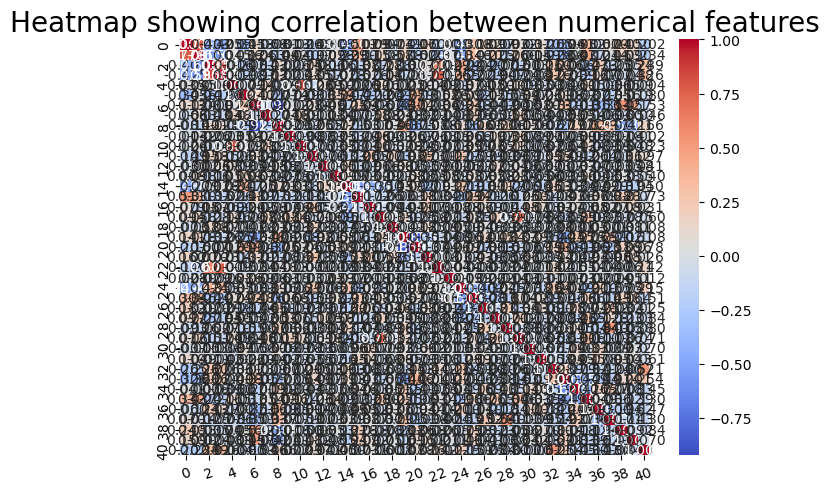

In [141]:
plt.figure()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".3f")
plt.xticks(rotation=20)
plt.tight_layout()
plt.title("Heatmap showing correlation between numerical features", fontsize=20)
plt.show();

In [142]:
corr.unstack().sort_values(ascending=True).drop_duplicates()

6   8    -0.922671
20  19   -0.858329
34  33   -0.625320
1   2    -0.599657
    3    -0.589836
            ...   
3   22    0.771946
1   0     0.777995
4   10    0.802166
3   2     0.858018
0   0     1.000000
Length: 821, dtype: float64

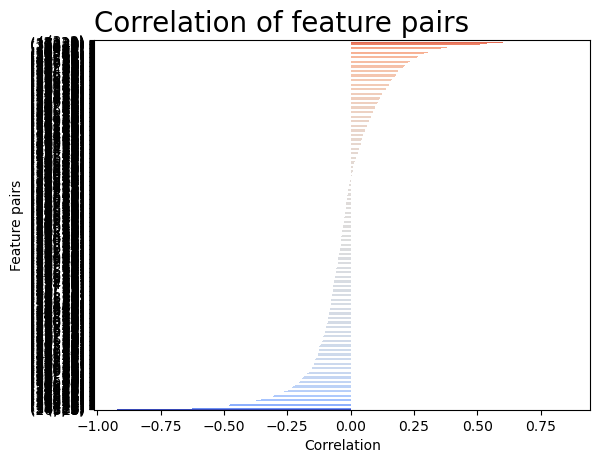

In [140]:
# drop year year correlation
corr2 = corr2.drop(corr2.index[-1])

# Normalize the correlation values to range [0, 1]
norm = plt.Normalize(vmin=corr2.min(), vmax=corr2.max())
# Choose a colormap, e.g., coolwarm
cmap = plt.get_cmap("coolwarm")
# Generate colors based on the normalized correlation values
colors = cmap(norm(corr2.values))
# Plot the bar chart with the colormap
corr2.plot(kind="barh", color=colors)
plt.title("Correlation of feature pairs", loc="left", fontsize=20)
plt.xlabel("Correlation")
plt.ylabel("Feature pairs")
plt.show();


In [ ]:
w0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)

rmse(y_val, y_pred)

Error:

```plaintext
---------------------------------------------------------------------------
LinAlgError                               Traceback (most recent call last)
Cell In[109], line 2
      1 X_train = prepare_X(df_train)
----> 2 w0, w = train_linear_regression(X_train, y_train)
      4 X_val = prepare_X(df_val)
      5 y_pred = w0 + X_val.dot(w)

Cell In[65], line 6
      3 X = np.column_stack([ones, X])
      5 XTX = X.T.dot(X)
----> 6 XTX_inv = np.linalg.inv(XTX)
      7 w_full = XTX_inv.dot(X.T).dot(y)
      9 return w_full[0], w_full[1:]

File /opt/homebrew/Caskroom/miniforge/base/envs/ML_Zoomcamp2024/lib/python3.11/site-packages/numpy/linalg/linalg.py:561, in inv(a)
    559 signature = 'D->D' if isComplexType(t) else 'd->d'
    560 extobj = get_linalg_error_extobj(_raise_linalgerror_singular)
--> 561 ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    562 return wrap(ainv.astype(result_t, copy=False))

File /opt/homebrew/Caskroom/miniforge/base/envs/ML_Zoomcamp2024/lib/python3.11/site-packages/numpy/linalg/linalg.py:112, in _raise_linalgerror_singular(err, flag)
    111 def _raise_linalgerror_singular(err, flag):
--> 112     raise LinAlgError("Singular matrix")

LinAlgError: Singular matrix
```


Other projects
- Predict the price of a house - e.g. boston dataset
- [https://archive.ics.uci.edu/ml/datasets.php?task=reg](https://archive.ics.uci.edu/ml/datasets.php?task=reg)
- [https://archive.ics.uci.edu/ml/Student+Performance](https://archive.ics.uci.edu/ml/Student+Performance)
- Links broken:
  - use [this](https://archive.ics.uci.edu/datasets)